In [1]:
import mahotas
import glob
import cv2
from matplotlib import pyplot as plt
import torch
import torchvision.transforms.functional as fn
import numpy as np
import pickle
%matplotlib inline

### Moments in computer vision

$I(x, y)$ is the value of an image at the position $x, y$. Typically moments are calculated for binarized images, where $I \in {0, 1}$. 

$$
 M_{ij} = \sum_{x}\sum_{y}x^iy^{\ j}I(x, y)
$$
$i = 0, \ j = 0 \implies M_{00}$ is the count of non-zero pixels in a binary image

$\mu_{ij}$ is the $ij$ central moment - the moment taken after translating the points to center their mean.

### Hu Moments & Zernike Moments

- Combinations of the $M_{ij}$ moments described above
- Rotation, translation and scale invariant

### Zernike Descriptor

In [2]:
class ZernikeMoments:
    def __init__(self, radius):
        self.radius = radius # Size of radius used when computing moments
    
    def describe(self, image): # Returns ZMoments of image
        return mahotas.features.zernike_moments(image, self.radius)

### Indexing Pokemon

In [3]:
desc = ZernikeMoments(21)
index = {}
id = 1
sprite_paths = glob.glob('../Pokemon Dataset/pokemon_jpg/pokemon_jpg/*.jpg')

for path in sprite_paths:
    pokemon = path.split('\\')[-1][:-4]
    sprite = cv2.imread(path)
    sprite = cv2.cvtColor(sprite, cv2.COLOR_BGR2GRAY)
    sprite = cv2.copyMakeBorder(sprite, 0, 0, 0, 0,
                                cv2.BORDER_CONSTANT, value=255) # Pad sprites with black pixels
    thresh = cv2.bitwise_not(sprite) # Invert image
    thresh[thresh > 0] = 255 # Background is black, things to pick as contours are white
    outline = np.zeros(sprite.shape, dtype='uint8')
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)[0] # ^ Outermost contours only
    # Contours are lists of (x, y) coordinates       ^ Simple contours to save memory
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[0] # Keep largest contour only
    outline = cv2.drawContours(outline, [cnts], -1, 255, -1) # Insert largest contour into an empty image
    # -1 -> All contours, 255 -> White, -1 -> Fill contour
    outline = cv2.bitwise_not(outline) #Invert image to opposite color (white -> black && black -> white)
    moments = desc.describe(outline)
    index[pokemon] = moments
    cv2.imwrite('seg_img/' + str(id) + '.jpg', outline)
    id+=1
    
# Save pokeshape index
with open('pokesprite_index', 'wb') as f:
    pickle.dump(index, f, protocol=2)

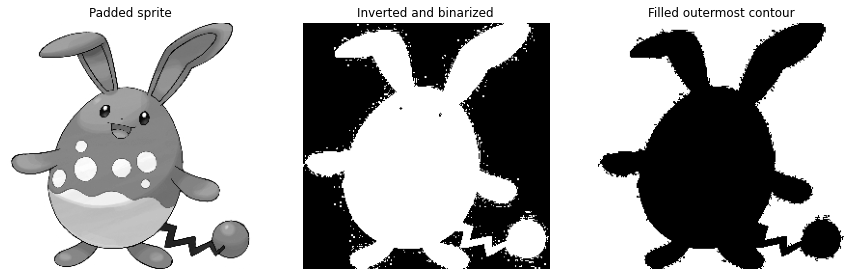

In [4]:
f, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
axs[0].imshow(sprite, cmap='gray'); axs[0].axis('off'); axs[0].set_title('Padded sprite')
axs[1].imshow(thresh, cmap='gray'); axs[1].axis('off'); axs[1].set_title('Inverted and binarized')
axs[2].imshow(outline, cmap='gray'); axs[2].axis('off'); axs[2].set_title('Filled outermost contour');